In [1]:
# First runnning of satellite to elevation, Image to image translation
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

C:\Users\AMRIT\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# define the discriminator model
def define_discriminator(image_shape):
 # weight initialization
 init = RandomNormal(stddev=0.02)
 # source image input
 in_src_image = Input(shape=image_shape)
 # target image input
 in_target_image = Input(shape=image_shape)
 # concatenate images channel-wise
 merged = Concatenate()([in_src_image, in_target_image])
 # C64
 d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
 d = LeakyReLU(alpha=0.2)(d)
 # C128
 d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 # C256
 d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 # C512
 d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 # second last output layer
 d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 # patch output
 d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
 patch_out = Activation('sigmoid')(d)
 # define model
 model = Model([in_src_image, in_target_image], patch_out)
 # compile model
 opt = Adam(lr=0.0002, beta_1=0.5)
 model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
 return model

In [3]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g


In [4]:
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g


In [5]:
# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
 # weight initialization
 init = RandomNormal(stddev=0.02)
 # image input
 in_image = Input(shape=image_shape)
 # encoder model
 e1 = define_encoder_block(in_image, 64, batchnorm=False)
 e2 = define_encoder_block(e1, 128)
 e3 = define_encoder_block(e2, 256)
 e4 = define_encoder_block(e3, 512)
 e5 = define_encoder_block(e4, 512)
 e6 = define_encoder_block(e5, 512)
 e7 = define_encoder_block(e6, 512)
 # bottleneck, no batch norm and relu
 b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
 b = Activation('relu')(b)
 # decoder model
 d1 = decoder_block(b, e7, 512)
 d2 = decoder_block(d1, e6, 512)
 d3 = decoder_block(d2, e5, 512)
 d4 = decoder_block(d3, e4, 512, dropout=False)
 d5 = decoder_block(d4, e3, 256, dropout=False)
 d6 = decoder_block(d5, e2, 128, dropout=False)
 d7 = decoder_block(d6, e1, 64, dropout=False)
 # output
 g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
 out_image = Activation('tanh')(g)
 # define model
 model = Model(in_image, out_image)
 return model

In [6]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False

    # define the source image
    in_src = Input(shape=image_shape)

    # connect the source image to the generator input
    gen_out = g_model(in_src)

    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])

    # src image as input, generated image, and classification output
    model = Model(in_src, [dis_out, gen_out])

    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1, 100])

    return model


In [7]:
# load and prepare training images
def load_real_samples(filename):
 # load compressed arrays
 data = load(filename)
 # unpack arrays
 X1, X2 = data['arr_0'], data['arr_1']
 # scale from [0,255] to [-1,1]
 X1 = (X1 - 127.5) / 127.5
 X2 = (X2 - 127.5) / 127.5
 return [X1, X2]

In [8]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
 # unpack dataset
 trainA, trainB = dataset
 # choose random instances
 ix = randint(0, trainA.shape[0], n_samples)
 # retrieve selected images
 X1, X2 = trainA[ix], trainB[ix]
 # generate 'real' class labels (1)
 y = ones((n_samples, patch_shape, patch_shape, 1))
 return [X1, X2], y

In [9]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
 # generate fake instance
 X = g_model.predict(samples)
 # create 'fake' class labels (0)
 y = zeros((len(X), patch_shape, patch_shape, 1))
 return X, y

In [10]:
from matplotlib import pyplot

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    
    # plot real source images
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        if i == 0:
            pyplot.title('Input')
        pyplot.imshow(X_realA[i])
    
    # plot generated target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        if i == 0:
            pyplot.title('Generated')
        pyplot.imshow(X_fakeB[i])
    
    # plot real target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples * 2 + i)
        pyplot.axis('off')
        if i == 0:
            pyplot.title('Target')
        pyplot.imshow(X_realB[i])
    
    # save plot to file
    filename1 = 'plot_%06d.png' % (step + 1)
    pyplot.savefig(filename1)
    pyplot.close()
    
    # save the generator model
    filename2 = 'model_%06d.h5' % (step + 1)
    g_model.save(filename2)
    print('> Saved: %s and %s' % (filename1, filename2))


In [11]:
from matplotlib import pyplot
import numpy as np

def train(d_model, g_model, gan_model, dataset, n_epochs=15, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    
    # unpack dataset
    trainA, trainB = dataset
    
    # List to store L1 loss values
    l1_losses = []
    
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs

    # Lists to store loss values
    d_losses_real, d_losses_fake, g_losses = [], [], []
    
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        d_losses_real.append(d_loss1)
        
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        d_losses_fake.append(d_loss2)
        
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        g_losses.append(g_loss)
        
        # L1 loss
        total_loss, d_loss, l1_loss = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        g_losses.append(total_loss)  # Total loss (discriminator + L1 loss)
        l1_losses.append(l1_loss)
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        
        # summarize model performance more frequently (every 10 steps)
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, dataset)

    # Plot the losses after training
    pyplot.figure(figsize=(8, 4))
    pyplot.plot(d_losses_real, label='Discriminator Loss - Real')
    pyplot.title('Discriminator Loss - Real')
    pyplot.xlabel('Batch')
    pyplot.ylabel('Loss')
    pyplot.legend()
    pyplot.savefig('discriminator_loss_real.png')
    pyplot.show()

    # Plot and save discriminator loss on fake samples
    pyplot.figure(figsize=(8, 4))
    pyplot.plot(d_losses_fake, label='Discriminator Loss - Fake')
    pyplot.title('Discriminator Loss - Fake')
    pyplot.xlabel('Batch')
    pyplot.ylabel('Loss')
    pyplot.legend()
    pyplot.savefig('discriminator_loss_fake.png')
    pyplot.show()

    # Plot and save generator loss
    pyplot.figure(figsize=(8, 4))
    pyplot.plot(g_losses, label='Generator Loss')
    pyplot.title('Generator Loss')
    pyplot.xlabel('Batch')
    pyplot.ylabel('Loss')
    pyplot.legend()
    pyplot.savefig('generator_loss.png')
    pyplot.show()
    
    pyplot.figure(figsize=(8, 4))
    pyplot.plot(l1_losses, label='L1 Loss')
    pyplot.title('L1 Loss')
    pyplot.xlabel('Batch')
    pyplot.ylabel('Loss')
    pyplot.legend()
    pyplot.savefig('l1_loss.png')
    pyplot.show()
    
     # Save L1 loss values to a CSV file
    np.savetxt('l1_loss_values.csv', l1_losses, delimiter=',')

    # Return the path to the saved L1 loss values
    return 'l1_loss_values.csv'


Loaded (50, 256, 256, 3) (50, 256, 256, 3)



C:\Users\AMRIT\anaconda3\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1/1 [==============================] - 2s 2s/step



>1, d1[0.211] d2[2.319] g[66.108]
1/1 [==============================] - 0s 301ms/step
>2, d1[1.344] d2[2.290] g[57.920]
1/1 [==============================] - 0s 260ms/step
>3, d1[0.569] d2[1.131] g[44.411]
1/1 [==============================] - 0s 306ms/step
>4, d1[0.695] d2[0.712] g[41.638]
1/1 [==============================] - 0s 337ms/step
>5, d1[0.754] d2[0.442] g[44.572]
1/1 [==============================] - 0s 359ms/step
>6, d1[0.487] d2[0.463] g[32.133]
1/1 [==============================] - 0s 324ms/step
>7, d1[0.495] d2[0.474] g[48.503]
1/1 [==============================] - 0s 271ms/step
>8, d1[0.491] d2[0.504] g[37.914]
1/1 [==============================] - 0s 248ms/step
>9, d1[0.341] d2[0.355] g[29.514]
1/1 [==============================] - 0s 238ms/step
>10, d1[0.494] d2[0.402] g[38.733]
1/1 [==============================] - 0s 499ms/step


C:\Users\AMRIT\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


> Saved: plot_000010.png and model_000010.h5
1/1 [==============================] - 0s 247ms/step
>11, d1[0.397] d2[0.478] g[65.572]
1/1 [==============================] - 0s 243ms/step
>12, d1[0.490] d2[0.380] g[62.390]
1/1 [==============================] - 0s 240ms/step
>13, d1[0.450] d2[0.418] g[35.558]
1/1 [==============================] - 0s 247ms/step
>14, d1[0.404] d2[0.452] g[47.920]
1/1 [==============================] - 0s 246ms/step
>15, d1[0.445] d2[0.396] g[28.702]
1/1 [==============================] - 0s 237ms/step
>16, d1[0.444] d2[0.345] g[36.984]
1/1 [==============================] - 0s 240ms/step
>17, d1[0.327] d2[0.415] g[27.404]
1/1 [==============================] - 0s 240ms/step
>18, d1[0.380] d2[0.244] g[20.601]
1/1 [==============================] - 0s 249ms/step
>19, d1[0.722] d2[0.450] g[56.731]
1/1 [==============================] - 0s 235ms/step
>20, d1[0.453] d2[0.496] g[48.122]
1/1 [==============================] - 0s 475ms/step


> Saved: plot_000020.png and model_000020.h5
1/1 [==============================] - 0s 248ms/step
>21, d1[0.356] d2[0.407] g[44.422]
1/1 [==============================] - 0s 238ms/step
>22, d1[0.403] d2[0.243] g[70.864]
1/1 [==============================] - 0s 240ms/step
>23, d1[0.289] d2[0.279] g[24.746]
1/1 [==============================] - 0s 245ms/step
>24, d1[0.337] d2[0.280] g[38.576]
1/1 [==============================] - 0s 240ms/step
>25, d1[0.360] d2[0.360] g[65.233]
1/1 [==============================] - 0s 409ms/step
>26, d1[0.302] d2[0.836] g[45.552]
1/1 [==============================] - 0s 246ms/step
>27, d1[0.404] d2[0.277] g[65.128]
1/1 [==============================] - 0s 429ms/step
>28, d1[0.304] d2[0.401] g[28.476]
1/1 [==============================] - 0s 250ms/step
>29, d1[0.567] d2[0.592] g[31.172]
1/1 [==============================] - 0s 234ms/step
>30, d1[0.698] d2[0.532] g[46.693]
1/1 [==============================] - 0s 486ms/step


> Saved: plot_000030.png and model_000030.h5
1/1 [==============================] - 0s 236ms/step
>31, d1[0.506] d2[0.468] g[36.763]
1/1 [==============================] - 0s 242ms/step
>32, d1[0.444] d2[0.562] g[26.230]
1/1 [==============================] - 0s 256ms/step
>33, d1[0.338] d2[0.532] g[40.760]
1/1 [==============================] - 0s 250ms/step
>34, d1[0.627] d2[0.389] g[49.449]
1/1 [==============================] - 0s 396ms/step
>35, d1[0.382] d2[0.319] g[45.649]
1/1 [==============================] - 0s 248ms/step
>36, d1[0.426] d2[0.358] g[32.986]
1/1 [==============================] - 0s 230ms/step
>37, d1[0.443] d2[0.388] g[25.840]
1/1 [==============================] - 0s 245ms/step
>38, d1[0.261] d2[0.350] g[71.742]
1/1 [==============================] - 0s 233ms/step
>39, d1[0.277] d2[0.343] g[25.709]
1/1 [==============================] - 0s 230ms/step
>40, d1[0.388] d2[0.185] g[37.484]
1/1 [==============================] - 0s 480ms/step


> Saved: plot_000040.png and model_000040.h5
1/1 [==============================] - 0s 240ms/step
>41, d1[0.384] d2[0.093] g[58.174]
1/1 [==============================] - 0s 235ms/step
>42, d1[0.236] d2[0.227] g[38.486]
1/1 [==============================] - 0s 281ms/step
>43, d1[0.170] d2[0.266] g[30.153]
1/1 [==============================] - 0s 247ms/step
>44, d1[0.218] d2[0.486] g[42.968]
1/1 [==============================] - 0s 228ms/step
>45, d1[0.685] d2[0.323] g[22.910]
1/1 [==============================] - 0s 229ms/step
>46, d1[0.336] d2[0.200] g[74.628]
1/1 [==============================] - 0s 233ms/step
>47, d1[0.253] d2[0.077] g[49.308]
1/1 [==============================] - 0s 230ms/step
>48, d1[0.153] d2[0.040] g[48.828]
1/1 [==============================] - 0s 230ms/step
>49, d1[0.343] d2[0.664] g[26.093]
1/1 [==============================] - 0s 240ms/step
>50, d1[0.191] d2[0.133] g[43.539]
1/1 [==============================] - 0s 480ms/step


> Saved: plot_000050.png and model_000050.h5
1/1 [==============================] - 0s 235ms/step
>51, d1[0.199] d2[0.040] g[68.834]
1/1 [==============================] - 0s 226ms/step
>52, d1[0.126] d2[0.355] g[37.857]
1/1 [==============================] - 0s 250ms/step
>53, d1[0.204] d2[0.080] g[61.851]
1/1 [==============================] - 0s 233ms/step
>54, d1[0.374] d2[0.879] g[58.830]
1/1 [==============================] - 0s 230ms/step
>55, d1[1.223] d2[0.339] g[42.297]
1/1 [==============================] - 0s 235ms/step
>56, d1[0.137] d2[0.595] g[43.044]
1/1 [==============================] - 0s 260ms/step
>57, d1[0.210] d2[0.145] g[30.976]
1/1 [==============================] - 0s 261ms/step
>58, d1[0.184] d2[0.056] g[65.116]
1/1 [==============================] - 0s 264ms/step
>59, d1[0.153] d2[0.180] g[62.536]
1/1 [==============================] - 0s 245ms/step
>60, d1[0.171] d2[0.048] g[47.180]
1/1 [==============================] - 0s 466ms/step


> Saved: plot_000060.png and model_000060.h5
1/1 [==============================] - 0s 257ms/step
>61, d1[0.094] d2[0.037] g[30.266]
1/1 [==============================] - 0s 234ms/step
>62, d1[0.049] d2[0.033] g[33.502]
1/1 [==============================] - 0s 234ms/step
>63, d1[0.048] d2[0.020] g[37.640]
1/1 [==============================] - 0s 232ms/step
>64, d1[0.065] d2[0.073] g[27.019]
1/1 [==============================] - 0s 244ms/step
>65, d1[0.227] d2[0.091] g[29.030]
1/1 [==============================] - 0s 247ms/step
>66, d1[0.032] d2[0.135] g[27.835]
1/1 [==============================] - 0s 232ms/step
>67, d1[0.041] d2[0.045] g[23.143]
1/1 [==============================] - 0s 232ms/step
>68, d1[0.022] d2[0.024] g[27.064]
1/1 [==============================] - 0s 239ms/step
>69, d1[0.096] d2[0.013] g[40.291]
1/1 [==============================] - 0s 230ms/step
>70, d1[0.073] d2[0.015] g[46.203]
1/1 [==============================] - 0s 490ms/step


> Saved: plot_000070.png and model_000070.h5
1/1 [==============================] - 0s 238ms/step
>71, d1[0.015] d2[0.154] g[36.504]
1/1 [==============================] - 0s 235ms/step
>72, d1[0.199] d2[0.200] g[27.008]
1/1 [==============================] - 0s 270ms/step
>73, d1[0.101] d2[0.038] g[27.092]
1/1 [==============================] - 0s 229ms/step
>74, d1[0.043] d2[0.298] g[22.849]
1/1 [==============================] - 0s 230ms/step
>75, d1[1.369] d2[0.202] g[20.015]
1/1 [==============================] - 0s 235ms/step
>76, d1[0.075] d2[0.159] g[23.772]
1/1 [==============================] - 0s 228ms/step
>77, d1[0.024] d2[0.178] g[36.638]
1/1 [==============================] - 0s 251ms/step
>78, d1[0.049] d2[0.112] g[33.815]
1/1 [==============================] - 0s 240ms/step
>79, d1[0.171] d2[0.034] g[32.680]
1/1 [==============================] - 0s 234ms/step
>80, d1[0.033] d2[0.037] g[43.807]
1/1 [==============================] - 0s 470ms/step


> Saved: plot_000080.png and model_000080.h5
1/1 [==============================] - 0s 241ms/step
>81, d1[0.057] d2[0.466] g[40.849]
1/1 [==============================] - 0s 240ms/step
>82, d1[0.636] d2[0.163] g[50.205]
1/1 [==============================] - 0s 230ms/step
>83, d1[0.291] d2[0.056] g[25.426]
1/1 [==============================] - 0s 229ms/step
>84, d1[0.016] d2[0.310] g[25.281]
1/1 [==============================] - 0s 255ms/step
>85, d1[0.042] d2[0.046] g[50.754]
1/1 [==============================] - 0s 238ms/step
>86, d1[0.062] d2[0.039] g[44.958]
1/1 [==============================] - 0s 240ms/step
>87, d1[0.066] d2[0.050] g[33.551]
1/1 [==============================] - 0s 240ms/step
>88, d1[0.048] d2[0.017] g[45.207]
1/1 [==============================] - 0s 220ms/step
>89, d1[0.412] d2[0.429] g[22.646]
1/1 [==============================] - 0s 233ms/step
>90, d1[0.017] d2[0.182] g[65.597]
1/1 [==============================] - 0s 470ms/step


> Saved: plot_000090.png and model_000090.h5
1/1 [==============================] - 0s 250ms/step
>91, d1[0.266] d2[0.074] g[31.245]
1/1 [==============================] - 0s 225ms/step
>92, d1[0.024] d2[0.174] g[43.304]
1/1 [==============================] - 0s 227ms/step
>93, d1[0.106] d2[0.015] g[33.587]
1/1 [==============================] - 0s 230ms/step
>94, d1[0.068] d2[0.020] g[48.943]
1/1 [==============================] - 0s 230ms/step
>95, d1[0.059] d2[0.962] g[37.201]
1/1 [==============================] - 0s 235ms/step
>96, d1[1.451] d2[0.035] g[19.323]
1/1 [==============================] - 0s 240ms/step
>97, d1[0.092] d2[0.138] g[30.793]
1/1 [==============================] - 0s 243ms/step
>98, d1[0.121] d2[0.275] g[48.050]
1/1 [==============================] - 0s 227ms/step
>99, d1[0.346] d2[0.038] g[37.977]
1/1 [==============================] - 0s 237ms/step
>100, d1[0.039] d2[0.296] g[27.536]
1/1 [==============================] - 1s 505ms/step


> Saved: plot_000100.png and model_000100.h5
1/1 [==============================] - 0s 245ms/step
>101, d1[0.064] d2[0.054] g[22.546]
1/1 [==============================] - 0s 240ms/step
>102, d1[0.054] d2[0.027] g[43.968]
1/1 [==============================] - 0s 249ms/step
>103, d1[0.034] d2[0.041] g[44.867]
1/1 [==============================] - 0s 230ms/step
>104, d1[0.028] d2[0.028] g[30.061]
1/1 [==============================] - 0s 250ms/step
>105, d1[0.095] d2[0.025] g[41.332]
1/1 [==============================] - 0s 290ms/step
>106, d1[0.012] d2[0.553] g[56.498]
1/1 [==============================] - 0s 245ms/step
>107, d1[0.034] d2[0.019] g[29.924]
1/1 [==============================] - 0s 266ms/step
>108, d1[1.958] d2[0.110] g[21.709]
1/1 [==============================] - 0s 236ms/step
>109, d1[0.850] d2[0.345] g[38.454]
1/1 [==============================] - 0s 240ms/step
>110, d1[0.449] d2[0.528] g[40.473]
1/1 [==============================] - 0s 491ms/step


> Saved: plot_000110.png and model_000110.h5
1/1 [==============================] - 0s 240ms/step
>111, d1[0.096] d2[0.254] g[37.083]
1/1 [==============================] - 0s 250ms/step
>112, d1[0.030] d2[0.233] g[41.644]
1/1 [==============================] - 0s 259ms/step
>113, d1[0.143] d2[0.086] g[25.440]
1/1 [==============================] - 0s 245ms/step
>114, d1[0.091] d2[0.119] g[37.702]
1/1 [==============================] - 0s 228ms/step
>115, d1[0.016] d2[0.059] g[56.704]
1/1 [==============================] - 0s 225ms/step
>116, d1[0.151] d2[0.154] g[16.924]
1/1 [==============================] - 0s 232ms/step
>117, d1[0.010] d2[0.062] g[40.512]
1/1 [==============================] - 0s 230ms/step
>118, d1[0.014] d2[0.042] g[42.380]
1/1 [==============================] - 0s 231ms/step
>119, d1[0.041] d2[0.055] g[27.632]
1/1 [==============================] - 0s 230ms/step
>120, d1[0.063] d2[0.051] g[32.784]
1/1 [==============================] - 0s 466ms/step


> Saved: plot_000120.png and model_000120.h5
1/1 [==============================] - 0s 235ms/step
>121, d1[0.028] d2[0.049] g[42.070]
1/1 [==============================] - 0s 230ms/step
>122, d1[0.022] d2[0.045] g[26.217]
1/1 [==============================] - 0s 223ms/step
>123, d1[0.008] d2[0.046] g[34.856]
1/1 [==============================] - 0s 230ms/step
>124, d1[0.044] d2[0.035] g[70.499]
1/1 [==============================] - 0s 240ms/step
>125, d1[0.010] d2[0.032] g[71.248]
1/1 [==============================] - 0s 230ms/step
>126, d1[0.046] d2[0.051] g[40.760]
1/1 [==============================] - 0s 235ms/step
>127, d1[0.016] d2[0.036] g[29.616]
1/1 [==============================] - 0s 240ms/step
>128, d1[0.008] d2[1.203] g[24.908]
1/1 [==============================] - 0s 236ms/step
>129, d1[0.144] d2[0.161] g[38.332]
1/1 [==============================] - 0s 230ms/step
>130, d1[1.063] d2[0.501] g[31.268]
1/1 [==============================] - 0s 468ms/step


> Saved: plot_000130.png and model_000130.h5
1/1 [==============================] - 0s 240ms/step
>131, d1[0.128] d2[0.268] g[37.998]
1/1 [==============================] - 0s 239ms/step
>132, d1[0.465] d2[0.225] g[45.471]
1/1 [==============================] - 0s 230ms/step
>133, d1[0.870] d2[0.897] g[20.128]
1/1 [==============================] - 0s 230ms/step
>134, d1[0.141] d2[0.369] g[39.251]
1/1 [==============================] - 0s 276ms/step
>135, d1[0.054] d2[0.186] g[20.847]
1/1 [==============================] - 0s 220ms/step
>136, d1[0.098] d2[0.109] g[22.893]
1/1 [==============================] - 0s 244ms/step
>137, d1[0.060] d2[0.056] g[32.082]
1/1 [==============================] - 0s 240ms/step
>138, d1[0.317] d2[0.140] g[25.930]
1/1 [==============================] - 0s 230ms/step
>139, d1[0.017] d2[0.065] g[51.650]
1/1 [==============================] - 0s 230ms/step
>140, d1[0.016] d2[0.049] g[67.324]
1/1 [==============================] - 0s 480ms/step


> Saved: plot_000140.png and model_000140.h5
1/1 [==============================] - 0s 243ms/step
>141, d1[0.014] d2[0.053] g[51.143]
1/1 [==============================] - 0s 230ms/step
>142, d1[0.367] d2[0.222] g[46.959]
1/1 [==============================] - 0s 254ms/step
>143, d1[0.016] d2[0.701] g[38.071]
1/1 [==============================] - 0s 254ms/step
>144, d1[0.499] d2[0.054] g[43.920]
1/1 [==============================] - 0s 240ms/step
>145, d1[0.017] d2[0.149] g[29.310]
1/1 [==============================] - 0s 246ms/step
>146, d1[0.323] d2[0.123] g[33.240]
1/1 [==============================] - 0s 245ms/step
>147, d1[0.011] d2[0.320] g[34.668]
1/1 [==============================] - 0s 230ms/step
>148, d1[0.012] d2[0.041] g[39.666]
1/1 [==============================] - 0s 230ms/step
>149, d1[0.018] d2[0.036] g[32.046]
1/1 [==============================] - 0s 251ms/step
>150, d1[0.025] d2[0.052] g[40.894]
1/1 [==============================] - 0s 460ms/step


> Saved: plot_000150.png and model_000150.h5
1/1 [==============================] - 0s 228ms/step
>151, d1[0.441] d2[0.102] g[39.266]
1/1 [==============================] - 0s 230ms/step
>152, d1[0.007] d2[0.275] g[30.751]
1/1 [==============================] - 0s 230ms/step
>153, d1[0.010] d2[1.670] g[16.466]
1/1 [==============================] - 0s 229ms/step
>154, d1[0.267] d2[0.158] g[39.999]
1/1 [==============================] - 0s 252ms/step
>155, d1[0.179] d2[0.645] g[24.352]
1/1 [==============================] - 0s 230ms/step
>156, d1[0.312] d2[0.699] g[49.229]
1/1 [==============================] - 0s 240ms/step
>157, d1[1.624] d2[0.062] g[46.273]
1/1 [==============================] - 0s 240ms/step
>158, d1[0.751] d2[0.647] g[46.897]
1/1 [==============================] - 0s 230ms/step
>159, d1[0.225] d2[0.532] g[71.745]
1/1 [==============================] - 0s 225ms/step
>160, d1[0.116] d2[0.373] g[27.203]
1/1 [==============================] - 0s 470ms/step


> Saved: plot_000160.png and model_000160.h5
1/1 [==============================] - 0s 235ms/step
>161, d1[0.320] d2[0.027] g[48.737]
1/1 [==============================] - 0s 223ms/step
>162, d1[0.124] d2[0.827] g[34.505]
1/1 [==============================] - 0s 229ms/step
>163, d1[0.706] d2[0.093] g[35.984]
1/1 [==============================] - 0s 240ms/step
>164, d1[0.126] d2[0.547] g[22.271]
1/1 [==============================] - 0s 237ms/step
>165, d1[0.461] d2[0.366] g[42.298]
1/1 [==============================] - 0s 236ms/step
>166, d1[0.217] d2[0.052] g[65.847]
1/1 [==============================] - 0s 237ms/step
>167, d1[0.196] d2[0.066] g[43.748]
1/1 [==============================] - 0s 260ms/step
>168, d1[0.087] d2[0.078] g[26.573]
1/1 [==============================] - 0s 231ms/step
>169, d1[0.045] d2[0.333] g[18.812]
1/1 [==============================] - 0s 250ms/step
>170, d1[0.680] d2[0.694] g[23.765]
1/1 [==============================] - 0s 470ms/step


> Saved: plot_000170.png and model_000170.h5
1/1 [==============================] - 0s 235ms/step
>171, d1[0.475] d2[0.121] g[23.426]
1/1 [==============================] - 0s 262ms/step
>172, d1[0.366] d2[0.930] g[32.794]
1/1 [==============================] - 0s 230ms/step
>173, d1[0.120] d2[0.089] g[29.675]
1/1 [==============================] - 0s 229ms/step
>174, d1[0.393] d2[0.494] g[13.208]
1/1 [==============================] - 0s 230ms/step
>175, d1[0.105] d2[0.099] g[46.972]
1/1 [==============================] - 0s 231ms/step
>176, d1[0.830] d2[0.156] g[53.914]
1/1 [==============================] - 0s 230ms/step
>177, d1[0.080] d2[0.376] g[32.715]
1/1 [==============================] - 0s 229ms/step
>178, d1[0.245] d2[0.188] g[22.762]
1/1 [==============================] - 0s 240ms/step
>179, d1[0.222] d2[0.137] g[15.906]
1/1 [==============================] - 0s 240ms/step
>180, d1[0.081] d2[0.516] g[31.877]
1/1 [==============================] - 0s 467ms/step


> Saved: plot_000180.png and model_000180.h5
1/1 [==============================] - 0s 270ms/step
>181, d1[0.998] d2[0.144] g[23.120]
1/1 [==============================] - 0s 225ms/step
>182, d1[0.241] d2[0.181] g[62.624]
1/1 [==============================] - 0s 235ms/step
>183, d1[0.486] d2[0.411] g[26.912]
1/1 [==============================] - 0s 226ms/step
>184, d1[0.029] d2[0.194] g[16.371]
1/1 [==============================] - 0s 227ms/step
>185, d1[0.336] d2[0.835] g[25.986]
1/1 [==============================] - 0s 222ms/step
>186, d1[0.416] d2[0.265] g[25.744]
1/1 [==============================] - 0s 220ms/step
>187, d1[0.393] d2[0.238] g[30.567]
1/1 [==============================] - 0s 231ms/step
>188, d1[0.057] d2[0.445] g[15.492]
1/1 [==============================] - 0s 235ms/step
>189, d1[0.951] d2[0.170] g[35.681]
1/1 [==============================] - 0s 240ms/step
>190, d1[0.050] d2[0.659] g[44.661]
1/1 [==============================] - 0s 467ms/step


> Saved: plot_000190.png and model_000190.h5
1/1 [==============================] - 0s 240ms/step
>191, d1[0.526] d2[0.525] g[32.089]
1/1 [==============================] - 0s 230ms/step
>192, d1[0.530] d2[0.275] g[15.784]
1/1 [==============================] - 0s 234ms/step
>193, d1[0.400] d2[0.410] g[21.408]
1/1 [==============================] - 0s 235ms/step
>194, d1[0.367] d2[0.340] g[26.726]
1/1 [==============================] - 0s 253ms/step
>195, d1[0.104] d2[0.227] g[31.139]
1/1 [==============================] - 0s 230ms/step
>196, d1[0.301] d2[0.168] g[62.278]
1/1 [==============================] - 0s 225ms/step
>197, d1[0.393] d2[0.634] g[19.798]
1/1 [==============================] - 0s 230ms/step
>198, d1[0.467] d2[0.410] g[21.902]
1/1 [==============================] - 0s 220ms/step
>199, d1[0.171] d2[0.280] g[31.019]
1/1 [==============================] - 0s 237ms/step
>200, d1[0.514] d2[0.388] g[18.334]
1/1 [==============================] - 0s 486ms/step


> Saved: plot_000200.png and model_000200.h5
1/1 [==============================] - 0s 243ms/step
>201, d1[0.333] d2[0.265] g[52.705]
1/1 [==============================] - 0s 230ms/step
>202, d1[0.386] d2[0.365] g[44.120]
1/1 [==============================] - 0s 240ms/step
>203, d1[0.330] d2[0.483] g[17.405]
1/1 [==============================] - 0s 239ms/step
>204, d1[0.065] d2[0.293] g[25.277]
1/1 [==============================] - 0s 250ms/step
>205, d1[0.339] d2[0.218] g[54.708]
1/1 [==============================] - 0s 230ms/step
>206, d1[0.487] d2[0.414] g[27.711]
1/1 [==============================] - 0s 230ms/step
>207, d1[0.037] d2[0.522] g[25.106]
1/1 [==============================] - 0s 247ms/step
>208, d1[0.532] d2[0.195] g[46.488]
1/1 [==============================] - 0s 225ms/step
>209, d1[0.369] d2[0.689] g[45.329]
1/1 [==============================] - 0s 235ms/step
>210, d1[0.432] d2[0.306] g[35.381]
1/1 [==============================] - 0s 466ms/step


> Saved: plot_000210.png and model_000210.h5
1/1 [==============================] - 0s 245ms/step
>211, d1[0.203] d2[0.185] g[70.455]
1/1 [==============================] - 0s 254ms/step
>212, d1[0.063] d2[0.166] g[56.246]
1/1 [==============================] - 0s 240ms/step
>213, d1[0.637] d2[0.227] g[19.777]
1/1 [==============================] - 0s 227ms/step
>214, d1[0.178] d2[0.219] g[22.223]
1/1 [==============================] - 0s 225ms/step
>215, d1[0.328] d2[0.384] g[28.632]
1/1 [==============================] - 0s 220ms/step
>216, d1[0.032] d2[0.203] g[66.076]
1/1 [==============================] - 0s 226ms/step
>217, d1[0.509] d2[0.274] g[38.207]
1/1 [==============================] - 0s 242ms/step
>218, d1[0.033] d2[0.183] g[60.244]
1/1 [==============================] - 0s 230ms/step
>219, d1[0.035] d2[0.164] g[36.272]
1/1 [==============================] - 0s 227ms/step
>220, d1[0.035] d2[0.119] g[36.373]
1/1 [==============================] - 0s 460ms/step


> Saved: plot_000220.png and model_000220.h5
1/1 [==============================] - 0s 261ms/step
>221, d1[0.039] d2[0.280] g[36.036]
1/1 [==============================] - 0s 227ms/step
>222, d1[0.222] d2[0.478] g[26.804]
1/1 [==============================] - 0s 230ms/step
>223, d1[0.491] d2[0.178] g[22.172]
1/1 [==============================] - 0s 232ms/step
>224, d1[0.623] d2[0.256] g[24.906]
1/1 [==============================] - 0s 230ms/step
>225, d1[0.031] d2[0.183] g[42.746]
1/1 [==============================] - 0s 250ms/step
>226, d1[0.033] d2[0.221] g[41.791]
1/1 [==============================] - 0s 254ms/step
>227, d1[0.038] d2[0.182] g[65.242]
1/1 [==============================] - 0s 275ms/step
>228, d1[0.233] d2[0.605] g[42.892]
1/1 [==============================] - 0s 242ms/step
>229, d1[0.764] d2[0.144] g[37.927]
1/1 [==============================] - 0s 245ms/step
>230, d1[0.182] d2[0.192] g[30.308]
1/1 [==============================] - 0s 470ms/step


> Saved: plot_000230.png and model_000230.h5
1/1 [==============================] - 0s 263ms/step
>231, d1[0.247] d2[0.186] g[23.018]
1/1 [==============================] - 0s 220ms/step
>232, d1[0.019] d2[0.151] g[39.383]
1/1 [==============================] - 0s 229ms/step
>233, d1[0.107] d2[0.142] g[28.691]
1/1 [==============================] - 0s 240ms/step
>234, d1[0.065] d2[0.362] g[32.951]
1/1 [==============================] - 0s 230ms/step
>235, d1[0.167] d2[0.118] g[16.307]
1/1 [==============================] - 0s 229ms/step
>236, d1[0.206] d2[0.135] g[16.762]
1/1 [==============================] - 0s 240ms/step
>237, d1[0.045] d2[0.450] g[30.008]
1/1 [==============================] - 0s 230ms/step
>238, d1[0.055] d2[0.102] g[56.711]
1/1 [==============================] - 0s 232ms/step
>239, d1[0.040] d2[0.802] g[66.444]
1/1 [==============================] - 0s 230ms/step
>240, d1[0.085] d2[0.083] g[27.531]
1/1 [==============================] - 0s 480ms/step


> Saved: plot_000240.png and model_000240.h5
1/1 [==============================] - 0s 250ms/step
>241, d1[1.032] d2[0.291] g[55.048]
1/1 [==============================] - 0s 235ms/step
>242, d1[0.917] d2[0.198] g[24.175]
1/1 [==============================] - 0s 225ms/step
>243, d1[0.401] d2[0.366] g[21.049]
1/1 [==============================] - 0s 227ms/step
>244, d1[0.517] d2[0.370] g[34.102]
1/1 [==============================] - 0s 224ms/step
>245, d1[0.287] d2[0.338] g[25.238]
1/1 [==============================] - 0s 236ms/step
>246, d1[0.049] d2[0.228] g[57.174]
1/1 [==============================] - 0s 232ms/step
>247, d1[0.099] d2[0.160] g[20.790]
1/1 [==============================] - 0s 282ms/step
>248, d1[0.102] d2[0.177] g[25.361]
1/1 [==============================] - 0s 243ms/step
>249, d1[0.398] d2[0.994] g[29.862]
1/1 [==============================] - 0s 228ms/step
>250, d1[0.780] d2[0.242] g[69.786]
1/1 [==============================] - 0s 485ms/step


> Saved: plot_000250.png and model_000250.h5
1/1 [==============================] - 0s 258ms/step
>251, d1[0.578] d2[0.319] g[28.040]
1/1 [==============================] - 0s 250ms/step
>252, d1[0.452] d2[0.347] g[21.020]
1/1 [==============================] - 0s 230ms/step
>253, d1[0.452] d2[0.353] g[25.459]
1/1 [==============================] - 0s 222ms/step
>254, d1[0.400] d2[0.331] g[50.466]
1/1 [==============================] - 0s 220ms/step
>255, d1[0.068] d2[0.312] g[42.489]
1/1 [==============================] - 0s 226ms/step
>256, d1[0.446] d2[0.330] g[24.738]
1/1 [==============================] - 0s 250ms/step
>257, d1[0.414] d2[0.388] g[26.738]
1/1 [==============================] - 0s 225ms/step
>258, d1[0.174] d2[0.307] g[38.022]
1/1 [==============================] - 0s 223ms/step
>259, d1[0.057] d2[0.259] g[63.107]
1/1 [==============================] - 0s 244ms/step
>260, d1[0.615] d2[0.297] g[19.842]
1/1 [==============================] - 0s 460ms/step


> Saved: plot_000260.png and model_000260.h5
1/1 [==============================] - 0s 236ms/step
>261, d1[0.374] d2[0.342] g[27.090]
1/1 [==============================] - 0s 230ms/step
>262, d1[0.063] d2[0.244] g[17.035]
1/1 [==============================] - 0s 220ms/step
>263, d1[0.145] d2[0.214] g[53.779]
1/1 [==============================] - 0s 248ms/step
>264, d1[0.040] d2[0.201] g[58.002]
1/1 [==============================] - 0s 240ms/step
>265, d1[0.096] d2[0.156] g[33.599]
1/1 [==============================] - 0s 222ms/step
>266, d1[0.722] d2[0.229] g[33.506]
1/1 [==============================] - 0s 230ms/step
>267, d1[0.476] d2[0.302] g[27.732]
1/1 [==============================] - 0s 238ms/step
>268, d1[0.266] d2[0.290] g[24.188]
1/1 [==============================] - 0s 224ms/step
>269, d1[0.317] d2[0.278] g[23.985]
1/1 [==============================] - 0s 233ms/step
>270, d1[0.131] d2[0.256] g[77.783]
1/1 [==============================] - 0s 465ms/step


> Saved: plot_000270.png and model_000270.h5
1/1 [==============================] - 0s 245ms/step
>271, d1[0.447] d2[0.462] g[42.437]
1/1 [==============================] - 0s 230ms/step
>272, d1[0.061] d2[1.174] g[38.017]
1/1 [==============================] - 0s 229ms/step
>273, d1[0.100] d2[0.161] g[42.001]
1/1 [==============================] - 0s 220ms/step
>274, d1[0.820] d2[0.176] g[51.290]
1/1 [==============================] - 0s 228ms/step
>275, d1[0.365] d2[0.253] g[30.540]
1/1 [==============================] - 0s 231ms/step
>276, d1[0.034] d2[0.275] g[49.861]
1/1 [==============================] - 0s 230ms/step
>277, d1[0.135] d2[0.233] g[41.450]
1/1 [==============================] - 0s 230ms/step
>278, d1[0.413] d2[0.198] g[18.863]
1/1 [==============================] - 0s 224ms/step
>279, d1[0.026] d2[0.764] g[14.616]
1/1 [==============================] - 0s 228ms/step
>280, d1[0.213] d2[0.158] g[22.407]
1/1 [==============================] - 0s 473ms/step


> Saved: plot_000280.png and model_000280.h5
1/1 [==============================] - 0s 260ms/step
>281, d1[0.090] d2[0.141] g[67.083]
1/1 [==============================] - 0s 285ms/step
>282, d1[0.524] d2[0.181] g[34.621]
1/1 [==============================] - 0s 389ms/step
>283, d1[0.031] d2[0.189] g[37.634]
1/1 [==============================] - 0s 262ms/step
>284, d1[0.217] d2[0.654] g[29.008]
1/1 [==============================] - 0s 245ms/step
>285, d1[0.258] d2[0.416] g[14.482]
1/1 [==============================] - 0s 260ms/step
>286, d1[0.414] d2[0.273] g[17.185]
1/1 [==============================] - 0s 232ms/step
>287, d1[0.180] d2[0.208] g[38.886]
1/1 [==============================] - 0s 235ms/step
>288, d1[0.248] d2[0.384] g[10.194]
1/1 [==============================] - 0s 245ms/step
>289, d1[0.538] d2[0.182] g[24.497]
1/1 [==============================] - 0s 235ms/step
>290, d1[0.362] d2[0.307] g[34.213]
1/1 [==============================] - 0s 495ms/step


> Saved: plot_000290.png and model_000290.h5
1/1 [==============================] - 0s 238ms/step
>291, d1[0.068] d2[0.226] g[15.549]
1/1 [==============================] - 0s 242ms/step
>292, d1[0.186] d2[0.223] g[27.028]
1/1 [==============================] - 0s 240ms/step
>293, d1[0.533] d2[0.267] g[21.760]
1/1 [==============================] - 0s 235ms/step
>294, d1[0.027] d2[0.710] g[62.831]
1/1 [==============================] - 0s 236ms/step
>295, d1[0.062] d2[0.381] g[34.712]
1/1 [==============================] - 0s 240ms/step
>296, d1[0.353] d2[0.379] g[22.634]
1/1 [==============================] - 0s 232ms/step
>297, d1[0.900] d2[0.209] g[25.996]
1/1 [==============================] - 0s 241ms/step
>298, d1[0.642] d2[0.223] g[32.532]
1/1 [==============================] - 0s 230ms/step
>299, d1[0.324] d2[0.288] g[26.488]
1/1 [==============================] - 0s 259ms/step
>300, d1[0.264] d2[0.391] g[16.944]
1/1 [==============================] - 0s 480ms/step


> Saved: plot_000300.png and model_000300.h5
1/1 [==============================] - 0s 240ms/step
>301, d1[0.236] d2[0.236] g[24.259]
1/1 [==============================] - 0s 235ms/step
>302, d1[0.219] d2[0.672] g[34.224]
1/1 [==============================] - 0s 230ms/step
>303, d1[0.581] d2[0.226] g[15.968]
1/1 [==============================] - 0s 226ms/step
>304, d1[0.143] d2[0.218] g[24.092]
1/1 [==============================] - 0s 230ms/step
>305, d1[0.234] d2[0.241] g[21.283]
1/1 [==============================] - 0s 230ms/step
>306, d1[0.407] d2[0.899] g[14.771]
1/1 [==============================] - 0s 255ms/step
>307, d1[0.449] d2[0.424] g[21.367]
1/1 [==============================] - 0s 243ms/step
>308, d1[0.260] d2[0.181] g[19.554]
1/1 [==============================] - 0s 230ms/step
>309, d1[0.275] d2[0.323] g[18.752]
1/1 [==============================] - 0s 232ms/step
>310, d1[0.215] d2[0.198] g[21.881]
1/1 [==============================] - 0s 480ms/step


> Saved: plot_000310.png and model_000310.h5
1/1 [==============================] - 0s 287ms/step
>311, d1[0.212] d2[0.228] g[20.250]
1/1 [==============================] - 0s 270ms/step
>312, d1[0.156] d2[0.189] g[17.721]
1/1 [==============================] - 0s 238ms/step
>313, d1[0.061] d2[0.391] g[29.530]
1/1 [==============================] - 0s 245ms/step
>314, d1[0.125] d2[0.262] g[22.951]
1/1 [==============================] - 0s 250ms/step
>315, d1[0.105] d2[0.148] g[39.453]
1/1 [==============================] - 0s 250ms/step
>316, d1[0.673] d2[0.193] g[22.570]
1/1 [==============================] - 0s 230ms/step
>317, d1[0.039] d2[0.247] g[40.050]
1/1 [==============================] - 0s 230ms/step
>318, d1[0.094] d2[0.335] g[22.266]
1/1 [==============================] - 0s 242ms/step
>319, d1[0.056] d2[0.157] g[67.411]
1/1 [==============================] - 0s 246ms/step
>320, d1[0.421] d2[0.154] g[23.611]
1/1 [==============================] - 0s 493ms/step


> Saved: plot_000320.png and model_000320.h5
1/1 [==============================] - 0s 240ms/step
>321, d1[0.353] d2[0.221] g[19.342]
1/1 [==============================] - 0s 264ms/step
>322, d1[0.040] d2[0.215] g[21.064]
1/1 [==============================] - 0s 239ms/step
>323, d1[0.099] d2[0.322] g[25.790]
1/1 [==============================] - 0s 242ms/step
>324, d1[0.047] d2[0.141] g[45.259]
1/1 [==============================] - 0s 235ms/step
>325, d1[0.315] d2[0.378] g[17.531]
1/1 [==============================] - 0s 245ms/step
>326, d1[0.654] d2[0.280] g[21.131]
1/1 [==============================] - 0s 240ms/step
>327, d1[0.173] d2[0.582] g[17.443]
1/1 [==============================] - 0s 231ms/step
>328, d1[0.044] d2[0.241] g[38.457]
1/1 [==============================] - 0s 230ms/step
>329, d1[0.534] d2[0.599] g[37.637]
1/1 [==============================] - 0s 280ms/step
>330, d1[0.723] d2[0.247] g[34.900]
1/1 [==============================] - 0s 470ms/step


> Saved: plot_000330.png and model_000330.h5
1/1 [==============================] - 0s 236ms/step
>331, d1[0.419] d2[0.463] g[46.165]
1/1 [==============================] - 0s 237ms/step
>332, d1[0.148] d2[0.454] g[13.592]
1/1 [==============================] - 0s 235ms/step
>333, d1[0.652] d2[0.227] g[42.411]
1/1 [==============================] - 0s 235ms/step
>334, d1[0.405] d2[0.484] g[11.809]
1/1 [==============================] - 0s 235ms/step
>335, d1[0.426] d2[0.403] g[19.970]
1/1 [==============================] - 0s 227ms/step
>336, d1[0.103] d2[0.396] g[34.114]
1/1 [==============================] - 0s 236ms/step
>337, d1[0.377] d2[0.215] g[24.542]
1/1 [==============================] - 0s 233ms/step
>338, d1[0.126] d2[0.246] g[23.617]
1/1 [==============================] - 0s 235ms/step
>339, d1[0.069] d2[0.207] g[27.820]
1/1 [==============================] - 0s 235ms/step
>340, d1[0.141] d2[0.197] g[33.002]
1/1 [==============================] - 0s 460ms/step


> Saved: plot_000340.png and model_000340.h5
1/1 [==============================] - 0s 240ms/step
>341, d1[0.683] d2[0.214] g[40.040]
1/1 [==============================] - 0s 243ms/step
>342, d1[0.089] d2[0.307] g[32.919]
1/1 [==============================] - 0s 239ms/step
>343, d1[0.624] d2[0.261] g[28.387]
1/1 [==============================] - 0s 233ms/step
>344, d1[0.449] d2[0.322] g[43.038]
1/1 [==============================] - 0s 251ms/step
>345, d1[0.136] d2[0.279] g[58.544]
1/1 [==============================] - 0s 250ms/step
>346, d1[0.168] d2[0.625] g[36.775]
1/1 [==============================] - 0s 251ms/step
>347, d1[0.153] d2[0.233] g[45.843]
1/1 [==============================] - 0s 254ms/step
>348, d1[0.698] d2[0.209] g[37.331]
1/1 [==============================] - 0s 235ms/step
>349, d1[0.513] d2[0.314] g[31.640]
1/1 [==============================] - 0s 225ms/step
>350, d1[0.238] d2[0.413] g[26.138]
1/1 [==============================] - 1s 505ms/step


> Saved: plot_000350.png and model_000350.h5
1/1 [==============================] - 0s 261ms/step
>351, d1[0.208] d2[0.255] g[18.271]
1/1 [==============================] - 0s 247ms/step
>352, d1[0.207] d2[0.373] g[23.954]
1/1 [==============================] - 0s 249ms/step
>353, d1[0.044] d2[0.194] g[36.428]
1/1 [==============================] - 0s 250ms/step
>354, d1[0.410] d2[0.456] g[27.749]
1/1 [==============================] - 0s 240ms/step
>355, d1[0.133] d2[0.184] g[20.411]
1/1 [==============================] - 0s 235ms/step
>356, d1[0.346] d2[0.242] g[21.524]
1/1 [==============================] - 0s 250ms/step
>357, d1[0.084] d2[0.180] g[28.818]
1/1 [==============================] - 0s 230ms/step
>358, d1[0.494] d2[0.245] g[30.724]
1/1 [==============================] - 0s 240ms/step
>359, d1[0.039] d2[0.217] g[57.049]
1/1 [==============================] - 0s 232ms/step
>360, d1[0.045] d2[0.823] g[30.061]
1/1 [==============================] - 0s 474ms/step


> Saved: plot_000360.png and model_000360.h5
1/1 [==============================] - 0s 242ms/step
>361, d1[0.111] d2[0.412] g[60.259]
1/1 [==============================] - 0s 240ms/step
>362, d1[0.739] d2[0.161] g[17.396]
1/1 [==============================] - 0s 260ms/step
>363, d1[0.386] d2[0.401] g[22.776]
1/1 [==============================] - 0s 235ms/step
>364, d1[0.147] d2[0.421] g[35.835]
1/1 [==============================] - 0s 240ms/step
>365, d1[0.143] d2[0.342] g[16.262]
1/1 [==============================] - 0s 240ms/step
>366, d1[0.703] d2[0.360] g[46.104]
1/1 [==============================] - 0s 245ms/step
>367, d1[0.579] d2[0.171] g[26.970]
1/1 [==============================] - 0s 247ms/step
>368, d1[0.368] d2[0.292] g[59.869]
1/1 [==============================] - 0s 240ms/step
>369, d1[0.129] d2[0.787] g[49.232]
1/1 [==============================] - 0s 240ms/step
>370, d1[0.120] d2[0.366] g[51.863]
1/1 [==============================] - 1s 505ms/step


> Saved: plot_000370.png and model_000370.h5
1/1 [==============================] - 0s 252ms/step
>371, d1[0.881] d2[0.193] g[27.327]
1/1 [==============================] - 0s 250ms/step
>372, d1[0.138] d2[0.471] g[46.460]
1/1 [==============================] - 0s 239ms/step
>373, d1[0.535] d2[0.363] g[20.540]
1/1 [==============================] - 0s 240ms/step
>374, d1[0.597] d2[0.226] g[48.477]
1/1 [==============================] - 0s 235ms/step
>375, d1[0.088] d2[0.375] g[39.510]
1/1 [==============================] - 0s 253ms/step
>376, d1[0.273] d2[0.337] g[29.905]
1/1 [==============================] - 0s 230ms/step
>377, d1[0.357] d2[0.300] g[31.083]
1/1 [==============================] - 0s 240ms/step
>378, d1[0.482] d2[0.259] g[46.424]
1/1 [==============================] - 0s 236ms/step
>379, d1[0.415] d2[0.373] g[21.649]
1/1 [==============================] - 0s 237ms/step
>380, d1[0.304] d2[0.275] g[25.658]
1/1 [==============================] - 0s 467ms/step


> Saved: plot_000380.png and model_000380.h5
1/1 [==============================] - 0s 245ms/step
>381, d1[0.194] d2[0.273] g[22.988]
1/1 [==============================] - 0s 255ms/step
>382, d1[0.231] d2[0.359] g[19.777]
1/1 [==============================] - 0s 235ms/step
>383, d1[0.273] d2[0.222] g[33.559]
1/1 [==============================] - 0s 236ms/step
>384, d1[0.397] d2[0.282] g[31.387]
1/1 [==============================] - 0s 230ms/step
>385, d1[0.215] d2[0.305] g[30.182]
1/1 [==============================] - 0s 240ms/step
>386, d1[0.039] d2[0.411] g[30.938]
1/1 [==============================] - 0s 240ms/step
>387, d1[0.385] d2[0.233] g[37.751]
1/1 [==============================] - 0s 250ms/step
>388, d1[0.386] d2[0.236] g[29.625]
1/1 [==============================] - 0s 240ms/step
>389, d1[0.045] d2[0.822] g[40.004]
1/1 [==============================] - 0s 235ms/step
>390, d1[0.081] d2[0.134] g[66.569]
1/1 [==============================] - 0s 500ms/step


> Saved: plot_000390.png and model_000390.h5
1/1 [==============================] - 0s 245ms/step
>391, d1[0.119] d2[0.117] g[37.056]
1/1 [==============================] - 0s 230ms/step
>392, d1[0.458] d2[0.452] g[49.750]
1/1 [==============================] - 0s 255ms/step
>393, d1[0.175] d2[0.365] g[33.353]
1/1 [==============================] - 0s 245ms/step
>394, d1[0.077] d2[0.111] g[30.721]
1/1 [==============================] - 0s 232ms/step
>395, d1[0.125] d2[0.129] g[28.846]
1/1 [==============================] - 0s 240ms/step
>396, d1[0.447] d2[0.224] g[25.781]
1/1 [==============================] - 0s 260ms/step
>397, d1[0.133] d2[0.207] g[27.818]
1/1 [==============================] - 0s 268ms/step
>398, d1[0.500] d2[0.233] g[35.395]
1/1 [==============================] - 0s 236ms/step
>399, d1[0.023] d2[0.783] g[35.983]
1/1 [==============================] - 0s 240ms/step
>400, d1[0.065] d2[0.157] g[65.424]
1/1 [==============================] - 0s 476ms/step


> Saved: plot_000400.png and model_000400.h5
1/1 [==============================] - 0s 255ms/step
>401, d1[0.184] d2[0.166] g[32.931]
1/1 [==============================] - 0s 245ms/step
>402, d1[0.586] d2[0.218] g[40.325]
1/1 [==============================] - 0s 236ms/step
>403, d1[0.043] d2[0.485] g[32.073]
1/1 [==============================] - 0s 239ms/step
>404, d1[0.083] d2[0.115] g[53.001]
1/1 [==============================] - 0s 250ms/step
>405, d1[0.281] d2[0.381] g[26.912]
1/1 [==============================] - 0s 242ms/step
>406, d1[0.096] d2[0.476] g[65.475]
1/1 [==============================] - 0s 236ms/step
>407, d1[0.922] d2[0.269] g[45.733]
1/1 [==============================] - 0s 240ms/step
>408, d1[0.656] d2[0.333] g[37.693]
1/1 [==============================] - 0s 235ms/step
>409, d1[0.438] d2[0.321] g[27.461]
1/1 [==============================] - 0s 235ms/step
>410, d1[0.145] d2[0.231] g[17.436]
1/1 [==============================] - 0s 489ms/step


> Saved: plot_000410.png and model_000410.h5
1/1 [==============================] - 0s 241ms/step
>411, d1[0.386] d2[0.328] g[25.691]
1/1 [==============================] - 0s 260ms/step
>412, d1[0.147] d2[0.234] g[36.669]
1/1 [==============================] - 0s 285ms/step
>413, d1[0.111] d2[0.165] g[32.963]
1/1 [==============================] - 0s 230ms/step
>414, d1[0.126] d2[0.162] g[28.857]
1/1 [==============================] - 0s 240ms/step
>415, d1[0.059] d2[0.715] g[28.691]
1/1 [==============================] - 0s 252ms/step
>416, d1[0.239] d2[0.104] g[59.082]
1/1 [==============================] - 0s 250ms/step
>417, d1[0.140] d2[0.268] g[47.673]
1/1 [==============================] - 0s 236ms/step
>418, d1[0.699] d2[0.619] g[35.068]
1/1 [==============================] - 0s 241ms/step
>419, d1[0.339] d2[0.334] g[27.081]
1/1 [==============================] - 0s 232ms/step
>420, d1[0.672] d2[0.363] g[49.554]
1/1 [==============================] - 0s 472ms/step


> Saved: plot_000420.png and model_000420.h5
1/1 [==============================] - 0s 260ms/step
>421, d1[0.411] d2[0.312] g[14.384]
1/1 [==============================] - 0s 240ms/step
>422, d1[0.328] d2[0.391] g[21.240]
1/1 [==============================] - 0s 238ms/step
>423, d1[0.097] d2[0.360] g[55.970]
1/1 [==============================] - 0s 233ms/step
>424, d1[0.484] d2[0.169] g[17.860]
1/1 [==============================] - 0s 236ms/step
>425, d1[0.161] d2[0.409] g[37.165]
1/1 [==============================] - 0s 255ms/step
>426, d1[0.218] d2[0.344] g[29.841]
1/1 [==============================] - 0s 230ms/step
>427, d1[0.088] d2[0.262] g[41.080]
1/1 [==============================] - 0s 241ms/step
>428, d1[0.100] d2[0.183] g[37.634]
1/1 [==============================] - 0s 225ms/step
>429, d1[0.854] d2[0.431] g[32.327]
1/1 [==============================] - 0s 258ms/step
>430, d1[0.643] d2[0.277] g[36.331]
1/1 [==============================] - 0s 480ms/step


> Saved: plot_000430.png and model_000430.h5
1/1 [==============================] - 0s 253ms/step
>431, d1[0.466] d2[0.554] g[18.781]
1/1 [==============================] - 0s 258ms/step
>432, d1[0.506] d2[0.351] g[29.902]
1/1 [==============================] - 0s 227ms/step
>433, d1[0.374] d2[0.377] g[32.236]
1/1 [==============================] - 0s 238ms/step
>434, d1[0.363] d2[0.344] g[26.651]
1/1 [==============================] - 0s 231ms/step
>435, d1[0.432] d2[0.374] g[26.617]
1/1 [==============================] - 0s 240ms/step
>436, d1[0.151] d2[0.407] g[26.185]
1/1 [==============================] - 0s 240ms/step
>437, d1[0.568] d2[0.274] g[29.259]
1/1 [==============================] - 0s 248ms/step
>438, d1[0.275] d2[0.382] g[45.453]
1/1 [==============================] - 0s 233ms/step
>439, d1[0.231] d2[0.306] g[33.574]
1/1 [==============================] - 0s 250ms/step
>440, d1[0.120] d2[0.360] g[29.323]
1/1 [==============================] - 0s 481ms/step


> Saved: plot_000440.png and model_000440.h5
1/1 [==============================] - 0s 265ms/step
>441, d1[0.149] d2[0.228] g[32.262]
1/1 [==============================] - 0s 242ms/step
>442, d1[0.148] d2[0.193] g[31.651]
1/1 [==============================] - 0s 244ms/step
>443, d1[0.093] d2[0.942] g[22.606]
1/1 [==============================] - 0s 235ms/step
>444, d1[0.383] d2[0.269] g[24.232]
1/1 [==============================] - 0s 251ms/step
>445, d1[0.491] d2[0.282] g[39.542]
1/1 [==============================] - 0s 237ms/step
>446, d1[0.650] d2[0.242] g[28.281]
1/1 [==============================] - 0s 234ms/step
>447, d1[0.363] d2[0.313] g[18.808]
1/1 [==============================] - 0s 235ms/step
>448, d1[0.468] d2[0.334] g[27.107]
1/1 [==============================] - 0s 236ms/step
>449, d1[0.100] d2[0.298] g[35.703]
1/1 [==============================] - 0s 230ms/step
>450, d1[0.305] d2[0.338] g[22.529]
1/1 [==============================] - 0s 480ms/step


> Saved: plot_000450.png and model_000450.h5
1/1 [==============================] - 0s 240ms/step
>451, d1[0.288] d2[0.450] g[25.510]
1/1 [==============================] - 0s 235ms/step
>452, d1[0.353] d2[0.340] g[18.658]
1/1 [==============================] - 0s 260ms/step
>453, d1[0.553] d2[0.379] g[22.733]
1/1 [==============================] - 0s 258ms/step
>454, d1[0.444] d2[0.353] g[25.834]
1/1 [==============================] - 0s 239ms/step
>455, d1[0.361] d2[0.345] g[16.589]
1/1 [==============================] - 0s 250ms/step
>456, d1[0.370] d2[0.366] g[23.282]
1/1 [==============================] - 0s 235ms/step
>457, d1[0.029] d2[0.266] g[27.382]
1/1 [==============================] - 0s 233ms/step
>458, d1[0.463] d2[0.323] g[19.206]
1/1 [==============================] - 0s 235ms/step
>459, d1[0.335] d2[0.374] g[26.064]
1/1 [==============================] - 0s 235ms/step
>460, d1[0.117] d2[0.255] g[54.411]
1/1 [==============================] - 0s 486ms/step


> Saved: plot_000460.png and model_000460.h5
1/1 [==============================] - 0s 245ms/step
>461, d1[0.066] d2[0.285] g[27.316]
1/1 [==============================] - 0s 231ms/step
>462, d1[0.621] d2[0.435] g[16.179]
1/1 [==============================] - 0s 240ms/step
>463, d1[0.308] d2[0.244] g[21.240]
1/1 [==============================] - 0s 230ms/step
>464, d1[0.068] d2[0.202] g[44.147]
1/1 [==============================] - 0s 240ms/step
>465, d1[0.434] d2[0.251] g[34.381]
1/1 [==============================] - 0s 233ms/step
>466, d1[0.356] d2[0.311] g[25.570]
1/1 [==============================] - 0s 250ms/step
>467, d1[0.034] d2[0.226] g[65.410]
1/1 [==============================] - 0s 230ms/step
>468, d1[0.054] d2[0.179] g[53.839]
1/1 [==============================] - 0s 231ms/step
>469, d1[0.052] d2[0.259] g[37.115]
1/1 [==============================] - 0s 244ms/step
>470, d1[0.438] d2[0.597] g[42.486]
1/1 [==============================] - 1s 510ms/step


> Saved: plot_000470.png and model_000470.h5
1/1 [==============================] - 0s 255ms/step
>471, d1[0.384] d2[0.555] g[43.562]
1/1 [==============================] - 0s 250ms/step
>472, d1[0.604] d2[0.283] g[29.611]
1/1 [==============================] - 0s 242ms/step
>473, d1[0.214] d2[0.292] g[35.561]
1/1 [==============================] - 0s 240ms/step
>474, d1[0.443] d2[0.261] g[22.160]
1/1 [==============================] - 0s 257ms/step
>475, d1[0.092] d2[0.395] g[29.317]
1/1 [==============================] - 0s 237ms/step
>476, d1[0.500] d2[0.378] g[33.686]
1/1 [==============================] - 0s 241ms/step
>477, d1[0.111] d2[0.182] g[53.295]
1/1 [==============================] - 0s 275ms/step
>478, d1[0.187] d2[0.517] g[29.194]
1/1 [==============================] - 0s 280ms/step
>479, d1[0.509] d2[0.294] g[27.512]
1/1 [==============================] - 0s 255ms/step
>480, d1[0.452] d2[0.246] g[41.544]
1/1 [==============================] - 0s 480ms/step


> Saved: plot_000480.png and model_000480.h5
1/1 [==============================] - 0s 257ms/step
>481, d1[0.091] d2[0.257] g[47.757]
1/1 [==============================] - 0s 248ms/step
>482, d1[0.686] d2[0.345] g[34.412]
1/1 [==============================] - 0s 236ms/step
>483, d1[0.170] d2[0.425] g[39.761]
1/1 [==============================] - 0s 230ms/step
>484, d1[0.109] d2[0.155] g[25.930]
1/1 [==============================] - 0s 234ms/step
>485, d1[0.110] d2[0.216] g[36.783]
1/1 [==============================] - 0s 235ms/step
>486, d1[0.784] d2[0.213] g[20.526]
1/1 [==============================] - 0s 231ms/step
>487, d1[0.404] d2[0.339] g[32.141]
1/1 [==============================] - 0s 253ms/step
>488, d1[0.032] d2[0.258] g[46.897]
1/1 [==============================] - 0s 250ms/step
>489, d1[0.048] d2[0.173] g[35.945]
1/1 [==============================] - 0s 234ms/step
>490, d1[0.513] d2[0.277] g[19.339]
1/1 [==============================] - 0s 470ms/step


> Saved: plot_000490.png and model_000490.h5
1/1 [==============================] - 0s 315ms/step
>491, d1[0.282] d2[0.745] g[23.921]
1/1 [==============================] - 0s 240ms/step
>492, d1[0.074] d2[0.137] g[63.436]
1/1 [==============================] - 0s 230ms/step
>493, d1[0.226] d2[0.223] g[24.094]
1/1 [==============================] - 0s 241ms/step
>494, d1[0.150] d2[0.174] g[33.829]
1/1 [==============================] - 0s 230ms/step
>495, d1[0.667] d2[0.396] g[35.287]
1/1 [==============================] - 0s 230ms/step
>496, d1[0.493] d2[0.328] g[43.517]
1/1 [==============================] - 0s 230ms/step
>497, d1[0.276] d2[0.415] g[27.692]
1/1 [==============================] - 0s 235ms/step
>498, d1[0.034] d2[0.222] g[51.837]
1/1 [==============================] - 0s 235ms/step
>499, d1[0.062] d2[0.259] g[57.913]
1/1 [==============================] - 0s 230ms/step
>500, d1[0.535] d2[0.171] g[21.723]
1/1 [==============================] - 0s 475ms/step


> Saved: plot_000500.png and model_000500.h5
1/1 [==============================] - 0s 268ms/step
>501, d1[0.057] d2[0.307] g[30.857]
1/1 [==============================] - 0s 238ms/step
>502, d1[0.548] d2[0.361] g[42.261]
1/1 [==============================] - 0s 245ms/step
>503, d1[0.048] d2[0.196] g[41.004]
1/1 [==============================] - 0s 240ms/step
>504, d1[0.603] d2[0.450] g[25.658]
1/1 [==============================] - 0s 255ms/step
>505, d1[0.492] d2[0.289] g[26.126]
1/1 [==============================] - 0s 230ms/step
>506, d1[0.043] d2[0.217] g[45.746]
1/1 [==============================] - 0s 301ms/step
>507, d1[0.579] d2[0.367] g[18.852]
1/1 [==============================] - 0s 235ms/step
>508, d1[0.289] d2[0.389] g[15.501]
1/1 [==============================] - 0s 239ms/step
>509, d1[0.408] d2[0.324] g[19.347]
1/1 [==============================] - 0s 240ms/step
>510, d1[0.212] d2[0.489] g[20.579]
1/1 [==============================] - 0s 465ms/step


> Saved: plot_000510.png and model_000510.h5
1/1 [==============================] - 0s 259ms/step
>511, d1[0.403] d2[0.244] g[14.632]
1/1 [==============================] - 0s 243ms/step
>512, d1[0.339] d2[0.299] g[21.590]
1/1 [==============================] - 0s 240ms/step
>513, d1[0.044] d2[0.255] g[30.156]
1/1 [==============================] - 0s 239ms/step
>514, d1[0.046] d2[0.222] g[27.386]
1/1 [==============================] - 0s 245ms/step
>515, d1[0.105] d2[0.263] g[20.305]
1/1 [==============================] - 0s 237ms/step
>516, d1[0.896] d2[0.278] g[21.556]
1/1 [==============================] - 0s 247ms/step
>517, d1[0.505] d2[0.386] g[16.687]
1/1 [==============================] - 0s 235ms/step
>518, d1[0.321] d2[0.408] g[23.137]
1/1 [==============================] - 0s 240ms/step
>519, d1[0.284] d2[0.398] g[19.263]
1/1 [==============================] - 0s 235ms/step
>520, d1[0.446] d2[0.271] g[16.437]
1/1 [==============================] - 0s 475ms/step


> Saved: plot_000520.png and model_000520.h5
1/1 [==============================] - 0s 250ms/step
>521, d1[0.489] d2[0.351] g[40.981]
1/1 [==============================] - 0s 290ms/step
>522, d1[0.263] d2[0.378] g[21.158]
1/1 [==============================] - 0s 242ms/step
>523, d1[0.235] d2[0.329] g[26.459]
1/1 [==============================] - 0s 235ms/step
>524, d1[0.221] d2[0.454] g[14.688]
1/1 [==============================] - 0s 230ms/step
>525, d1[0.440] d2[0.283] g[27.061]
1/1 [==============================] - 0s 252ms/step
>526, d1[0.143] d2[0.298] g[20.436]
1/1 [==============================] - 0s 228ms/step
>527, d1[0.454] d2[0.293] g[23.397]
1/1 [==============================] - 0s 250ms/step
>528, d1[0.148] d2[0.645] g[18.013]
1/1 [==============================] - 0s 240ms/step
>529, d1[0.391] d2[0.271] g[35.205]
1/1 [==============================] - 0s 240ms/step
>530, d1[0.093] d2[0.227] g[35.563]
1/1 [==============================] - 0s 470ms/step


> Saved: plot_000530.png and model_000530.h5
1/1 [==============================] - 0s 270ms/step
>531, d1[0.619] d2[0.432] g[37.156]
1/1 [==============================] - 0s 228ms/step
>532, d1[0.552] d2[0.286] g[37.398]
1/1 [==============================] - 0s 226ms/step
>533, d1[0.381] d2[0.564] g[23.218]
1/1 [==============================] - 0s 232ms/step
>534, d1[0.088] d2[0.252] g[27.873]
1/1 [==============================] - 0s 224ms/step
>535, d1[0.159] d2[0.363] g[20.508]
1/1 [==============================] - 0s 230ms/step
>536, d1[0.638] d2[0.190] g[18.977]
1/1 [==============================] - 0s 226ms/step
>537, d1[0.441] d2[0.454] g[17.037]
1/1 [==============================] - 0s 240ms/step
>538, d1[0.259] d2[0.404] g[16.868]
1/1 [==============================] - 0s 230ms/step
>539, d1[0.489] d2[0.316] g[19.416]
1/1 [==============================] - 0s 234ms/step
>540, d1[0.035] d2[0.233] g[27.472]
1/1 [==============================] - 0s 460ms/step


> Saved: plot_000540.png and model_000540.h5
1/1 [==============================] - 0s 231ms/step
>541, d1[0.077] d2[0.298] g[29.465]
1/1 [==============================] - 0s 240ms/step
>542, d1[0.732] d2[0.465] g[17.525]
1/1 [==============================] - 0s 240ms/step
>543, d1[0.648] d2[0.261] g[14.522]
1/1 [==============================] - 0s 230ms/step
>544, d1[0.395] d2[0.382] g[23.896]
1/1 [==============================] - 0s 230ms/step
>545, d1[0.095] d2[0.275] g[27.807]
1/1 [==============================] - 0s 240ms/step
>546, d1[0.439] d2[0.333] g[14.672]
1/1 [==============================] - 0s 227ms/step
>547, d1[0.309] d2[0.489] g[14.941]
1/1 [==============================] - 0s 225ms/step
>548, d1[0.084] d2[0.335] g[26.665]
1/1 [==============================] - 0s 230ms/step
>549, d1[0.102] d2[0.189] g[43.929]
1/1 [==============================] - 0s 230ms/step
>550, d1[0.157] d2[0.122] g[44.855]
1/1 [==============================] - 0s 480ms/step


> Saved: plot_000550.png and model_000550.h5
1/1 [==============================] - 0s 231ms/step
>551, d1[0.176] d2[0.347] g[47.037]
1/1 [==============================] - 0s 226ms/step
>552, d1[0.197] d2[0.240] g[20.730]
1/1 [==============================] - 0s 230ms/step
>553, d1[0.682] d2[0.604] g[30.065]
1/1 [==============================] - 0s 225ms/step
>554, d1[0.604] d2[0.284] g[26.639]
1/1 [==============================] - 0s 219ms/step
>555, d1[0.557] d2[0.361] g[21.043]
1/1 [==============================] - 0s 240ms/step
>556, d1[0.292] d2[0.377] g[14.305]
1/1 [==============================] - 0s 223ms/step
>557, d1[0.135] d2[0.298] g[34.499]
1/1 [==============================] - 0s 230ms/step
>558, d1[0.577] d2[0.316] g[23.659]
1/1 [==============================] - 0s 225ms/step
>559, d1[0.112] d2[0.279] g[19.842]
1/1 [==============================] - 0s 265ms/step
>560, d1[0.370] d2[0.712] g[42.239]
1/1 [==============================] - 0s 459ms/step


> Saved: plot_000560.png and model_000560.h5
1/1 [==============================] - 0s 255ms/step
>561, d1[0.458] d2[0.253] g[50.244]
1/1 [==============================] - 0s 255ms/step
>562, d1[0.381] d2[0.384] g[17.205]
1/1 [==============================] - 0s 235ms/step
>563, d1[0.512] d2[0.403] g[22.205]
1/1 [==============================] - 0s 243ms/step
>564, d1[0.047] d2[0.363] g[34.358]
1/1 [==============================] - 0s 275ms/step
>565, d1[0.251] d2[0.192] g[18.851]
1/1 [==============================] - 0s 225ms/step
>566, d1[0.523] d2[0.505] g[26.179]
1/1 [==============================] - 0s 238ms/step
>567, d1[0.487] d2[0.317] g[24.957]
1/1 [==============================] - 0s 250ms/step
>568, d1[0.396] d2[0.387] g[18.068]
1/1 [==============================] - 0s 245ms/step
>569, d1[0.086] d2[0.365] g[30.082]
1/1 [==============================] - 0s 232ms/step
>570, d1[0.611] d2[0.267] g[29.264]
1/1 [==============================] - 0s 465ms/step


> Saved: plot_000570.png and model_000570.h5
1/1 [==============================] - 0s 230ms/step
>571, d1[0.053] d2[0.401] g[42.392]
1/1 [==============================] - 0s 240ms/step
>572, d1[0.078] d2[0.154] g[25.910]
1/1 [==============================] - 0s 226ms/step
>573, d1[0.649] d2[0.287] g[28.826]
1/1 [==============================] - 0s 237ms/step
>574, d1[0.605] d2[0.323] g[22.997]
1/1 [==============================] - 0s 229ms/step
>575, d1[0.282] d2[0.544] g[16.465]
1/1 [==============================] - 0s 230ms/step
>576, d1[0.046] d2[0.272] g[37.279]
1/1 [==============================] - 0s 280ms/step
>577, d1[0.698] d2[0.244] g[20.202]
1/1 [==============================] - 0s 246ms/step
>578, d1[0.386] d2[0.395] g[20.467]
1/1 [==============================] - 0s 315ms/step
>579, d1[0.425] d2[0.398] g[18.878]
1/1 [==============================] - 0s 239ms/step
>580, d1[0.385] d2[0.404] g[14.857]
1/1 [==============================] - 1s 543ms/step


> Saved: plot_000580.png and model_000580.h5
1/1 [==============================] - 0s 256ms/step
>581, d1[0.237] d2[0.363] g[39.094]
1/1 [==============================] - 0s 260ms/step
>582, d1[0.234] d2[0.368] g[22.275]
1/1 [==============================] - 0s 254ms/step
>583, d1[0.465] d2[0.315] g[15.487]
1/1 [==============================] - 0s 270ms/step
>584, d1[0.420] d2[0.380] g[15.394]
1/1 [==============================] - 0s 240ms/step
>585, d1[0.364] d2[0.408] g[17.983]
1/1 [==============================] - 0s 246ms/step
>586, d1[0.190] d2[0.355] g[13.721]
1/1 [==============================] - 0s 240ms/step
>587, d1[0.080] d2[0.296] g[24.632]
1/1 [==============================] - 0s 228ms/step
>588, d1[0.512] d2[0.375] g[16.770]
1/1 [==============================] - 0s 233ms/step
>589, d1[0.365] d2[0.553] g[18.338]
1/1 [==============================] - 0s 250ms/step
>590, d1[0.289] d2[0.277] g[14.830]
1/1 [==============================] - 0s 490ms/step


> Saved: plot_000590.png and model_000590.h5
1/1 [==============================] - 0s 238ms/step
>591, d1[0.583] d2[0.250] g[19.800]
1/1 [==============================] - 0s 236ms/step
>592, d1[0.406] d2[0.380] g[22.258]
1/1 [==============================] - 0s 239ms/step
>593, d1[0.077] d2[0.309] g[31.196]
1/1 [==============================] - 0s 230ms/step
>594, d1[0.561] d2[0.302] g[16.486]
1/1 [==============================] - 0s 225ms/step
>595, d1[0.213] d2[0.350] g[13.984]
1/1 [==============================] - 0s 236ms/step
>596, d1[0.051] d2[0.348] g[37.291]
1/1 [==============================] - 0s 230ms/step
>597, d1[0.573] d2[0.220] g[19.943]
1/1 [==============================] - 0s 230ms/step
>598, d1[0.183] d2[0.442] g[55.707]
1/1 [==============================] - 0s 227ms/step
>599, d1[0.522] d2[0.341] g[21.629]
1/1 [==============================] - 0s 230ms/step
>600, d1[0.111] d2[0.257] g[25.535]
1/1 [==============================] - 1s 530ms/step


> Saved: plot_000600.png and model_000600.h5
1/1 [==============================] - 0s 301ms/step
>601, d1[0.367] d2[0.871] g[16.125]
1/1 [==============================] - 0s 292ms/step
>602, d1[0.447] d2[0.185] g[19.222]
1/1 [==============================] - 0s 265ms/step
>603, d1[0.189] d2[0.210] g[19.584]
1/1 [==============================] - 0s 262ms/step
>604, d1[0.075] d2[0.322] g[29.661]
1/1 [==============================] - 0s 280ms/step
>605, d1[0.821] d2[0.209] g[24.887]
1/1 [==============================] - 0s 255ms/step
>606, d1[0.510] d2[0.473] g[22.987]
1/1 [==============================] - 0s 266ms/step
>607, d1[0.093] d2[0.353] g[26.214]
1/1 [==============================] - 0s 241ms/step
>608, d1[0.555] d2[0.307] g[31.757]
1/1 [==============================] - 0s 250ms/step
>609, d1[0.520] d2[0.393] g[17.080]
1/1 [==============================] - 0s 240ms/step
>610, d1[0.241] d2[0.374] g[14.759]
1/1 [==============================] - 0s 470ms/step


> Saved: plot_000610.png and model_000610.h5
1/1 [==============================] - 0s 240ms/step
>611, d1[0.151] d2[0.374] g[39.975]
1/1 [==============================] - 0s 226ms/step
>612, d1[0.088] d2[0.398] g[44.868]
1/1 [==============================] - 0s 227ms/step
>613, d1[0.212] d2[0.172] g[19.138]
1/1 [==============================] - 0s 240ms/step
>614, d1[0.931] d2[0.230] g[44.447]
1/1 [==============================] - 0s 230ms/step
>615, d1[0.252] d2[0.940] g[31.887]
1/1 [==============================] - 0s 239ms/step
>616, d1[0.649] d2[0.242] g[41.760]
1/1 [==============================] - 0s 229ms/step
>617, d1[0.536] d2[0.359] g[18.202]
1/1 [==============================] - 0s 240ms/step
>618, d1[0.356] d2[0.475] g[16.671]
1/1 [==============================] - 0s 238ms/step
>619, d1[0.066] d2[0.275] g[33.345]
1/1 [==============================] - 0s 230ms/step
>620, d1[0.529] d2[0.294] g[12.710]
1/1 [==============================] - 0s 465ms/step


> Saved: plot_000620.png and model_000620.h5
1/1 [==============================] - 0s 248ms/step
>621, d1[0.486] d2[0.391] g[26.089]
1/1 [==============================] - 0s 234ms/step
>622, d1[0.387] d2[0.442] g[19.160]
1/1 [==============================] - 0s 235ms/step
>623, d1[0.376] d2[0.415] g[18.660]
1/1 [==============================] - 0s 232ms/step
>624, d1[0.353] d2[0.398] g[13.691]
1/1 [==============================] - 0s 235ms/step
>625, d1[0.352] d2[0.420] g[33.629]
1/1 [==============================] - 0s 230ms/step
>626, d1[0.270] d2[0.347] g[19.017]
1/1 [==============================] - 0s 227ms/step
>627, d1[0.243] d2[0.304] g[27.303]
1/1 [==============================] - 0s 220ms/step
>628, d1[0.489] d2[0.372] g[19.089]
1/1 [==============================] - 0s 242ms/step
>629, d1[0.370] d2[0.407] g[16.064]
1/1 [==============================] - 0s 240ms/step
>630, d1[0.187] d2[0.342] g[40.147]
1/1 [==============================] - 0s 487ms/step


> Saved: plot_000630.png and model_000630.h5
1/1 [==============================] - 0s 241ms/step
>631, d1[0.273] d2[0.541] g[22.099]
1/1 [==============================] - 0s 229ms/step
>632, d1[0.111] d2[0.233] g[21.427]
1/1 [==============================] - 0s 223ms/step
>633, d1[0.189] d2[0.285] g[21.640]
1/1 [==============================] - 0s 230ms/step
>634, d1[0.797] d2[0.235] g[21.933]
1/1 [==============================] - 0s 229ms/step
>635, d1[0.287] d2[0.410] g[16.815]
1/1 [==============================] - 0s 225ms/step
>636, d1[0.177] d2[0.380] g[21.174]
1/1 [==============================] - 0s 230ms/step
>637, d1[0.345] d2[0.374] g[36.731]
1/1 [==============================] - 0s 226ms/step
>638, d1[0.149] d2[0.273] g[23.381]
1/1 [==============================] - 0s 250ms/step
>639, d1[0.788] d2[0.254] g[31.871]
1/1 [==============================] - 0s 251ms/step
>640, d1[0.374] d2[0.462] g[18.080]
1/1 [==============================] - 0s 490ms/step


> Saved: plot_000640.png and model_000640.h5
1/1 [==============================] - 0s 240ms/step
>641, d1[0.401] d2[0.384] g[19.843]
1/1 [==============================] - 0s 238ms/step
>642, d1[0.080] d2[0.313] g[29.412]
1/1 [==============================] - 0s 225ms/step
>643, d1[0.096] d2[0.175] g[34.816]
1/1 [==============================] - 0s 237ms/step
>644, d1[0.752] d2[0.254] g[16.603]
1/1 [==============================] - 0s 227ms/step
>645, d1[0.054] d2[0.279] g[40.627]
1/1 [==============================] - 0s 235ms/step
>646, d1[0.087] d2[0.279] g[27.064]
1/1 [==============================] - 0s 277ms/step
>647, d1[0.201] d2[0.319] g[18.720]
1/1 [==============================] - 0s 228ms/step
>648, d1[0.761] d2[0.222] g[16.163]
1/1 [==============================] - 0s 273ms/step
>649, d1[0.563] d2[0.380] g[21.322]
1/1 [==============================] - 0s 230ms/step
>650, d1[0.378] d2[0.476] g[20.187]
1/1 [==============================] - 0s 475ms/step


> Saved: plot_000650.png and model_000650.h5
1/1 [==============================] - 0s 255ms/step
>651, d1[0.247] d2[0.434] g[32.228]
1/1 [==============================] - 0s 225ms/step
>652, d1[0.462] d2[0.370] g[19.386]
1/1 [==============================] - 0s 243ms/step
>653, d1[0.339] d2[0.376] g[19.772]
1/1 [==============================] - 0s 250ms/step
>654, d1[0.220] d2[0.345] g[19.954]
1/1 [==============================] - 0s 242ms/step
>655, d1[0.378] d2[0.380] g[17.164]
1/1 [==============================] - 0s 225ms/step
>656, d1[0.488] d2[0.364] g[17.767]
1/1 [==============================] - 0s 228ms/step
>657, d1[0.092] d2[0.311] g[22.368]
1/1 [==============================] - 0s 226ms/step
>658, d1[0.507] d2[0.312] g[31.278]
1/1 [==============================] - 0s 262ms/step
>659, d1[0.054] d2[0.257] g[50.576]
1/1 [==============================] - 0s 265ms/step
>660, d1[0.118] d2[0.218] g[19.430]
1/1 [==============================] - 1s 505ms/step


> Saved: plot_000660.png and model_000660.h5
1/1 [==============================] - 0s 290ms/step
>661, d1[0.412] d2[0.258] g[18.225]
1/1 [==============================] - 0s 240ms/step
>662, d1[0.404] d2[0.522] g[18.340]
1/1 [==============================] - 0s 237ms/step
>663, d1[0.326] d2[0.554] g[14.399]
1/1 [==============================] - 0s 229ms/step
>664, d1[0.080] d2[0.180] g[27.709]
1/1 [==============================] - 0s 230ms/step
>665, d1[0.807] d2[0.238] g[13.526]
1/1 [==============================] - 0s 228ms/step
>666, d1[0.503] d2[0.452] g[17.233]
1/1 [==============================] - 0s 235ms/step
>667, d1[0.290] d2[0.455] g[22.499]
1/1 [==============================] - 0s 230ms/step
>668, d1[0.408] d2[0.387] g[37.743]
1/1 [==============================] - 0s 230ms/step
>669, d1[0.415] d2[0.421] g[20.330]
1/1 [==============================] - 0s 230ms/step
>670, d1[0.322] d2[0.405] g[11.196]
1/1 [==============================] - 0s 478ms/step


> Saved: plot_000670.png and model_000670.h5
1/1 [==============================] - 0s 290ms/step
>671, d1[0.065] d2[0.252] g[38.614]
1/1 [==============================] - 0s 242ms/step
>672, d1[0.602] d2[0.307] g[13.119]
1/1 [==============================] - 0s 237ms/step
>673, d1[0.444] d2[0.450] g[21.582]
1/1 [==============================] - 0s 226ms/step
>674, d1[0.355] d2[0.432] g[27.120]
1/1 [==============================] - 0s 229ms/step
>675, d1[0.411] d2[0.399] g[14.445]
1/1 [==============================] - 0s 236ms/step
>676, d1[0.369] d2[0.437] g[9.889]
1/1 [==============================] - 0s 230ms/step
>677, d1[0.321] d2[0.365] g[13.235]
1/1 [==============================] - 0s 224ms/step
>678, d1[0.216] d2[0.337] g[29.744]
1/1 [==============================] - 0s 230ms/step
>679, d1[0.511] d2[0.361] g[14.779]
1/1 [==============================] - 0s 220ms/step
>680, d1[0.068] d2[0.258] g[45.756]
1/1 [==============================] - 0s 469ms/step


> Saved: plot_000680.png and model_000680.h5
1/1 [==============================] - 0s 258ms/step
>681, d1[0.221] d2[0.230] g[23.252]
1/1 [==============================] - 0s 231ms/step
>682, d1[0.226] d2[0.255] g[26.713]
1/1 [==============================] - 0s 270ms/step
>683, d1[0.178] d2[0.502] g[29.658]
1/1 [==============================] - 0s 235ms/step
>684, d1[0.118] d2[0.520] g[27.346]
1/1 [==============================] - 0s 237ms/step
>685, d1[1.095] d2[0.170] g[27.329]
1/1 [==============================] - 0s 240ms/step
>686, d1[0.352] d2[0.300] g[22.055]
1/1 [==============================] - 0s 231ms/step
>687, d1[0.510] d2[0.448] g[20.542]
1/1 [==============================] - 0s 220ms/step
>688, d1[0.246] d2[0.408] g[21.723]
1/1 [==============================] - 0s 251ms/step
>689, d1[0.228] d2[0.303] g[15.264]
1/1 [==============================] - 0s 235ms/step
>690, d1[0.611] d2[0.305] g[30.597]
1/1 [==============================] - 0s 490ms/step


> Saved: plot_000690.png and model_000690.h5
1/1 [==============================] - 0s 259ms/step
>691, d1[0.480] d2[0.421] g[24.272]
1/1 [==============================] - 0s 247ms/step
>692, d1[0.325] d2[0.564] g[21.970]
1/1 [==============================] - 0s 230ms/step
>693, d1[0.346] d2[0.483] g[20.207]
1/1 [==============================] - 0s 230ms/step
>694, d1[0.537] d2[0.332] g[16.224]
1/1 [==============================] - 0s 250ms/step
>695, d1[0.419] d2[0.413] g[22.905]
1/1 [==============================] - 0s 225ms/step
>696, d1[0.152] d2[0.335] g[25.082]
1/1 [==============================] - 0s 235ms/step
>697, d1[0.195] d2[0.255] g[24.130]
1/1 [==============================] - 0s 230ms/step
>698, d1[0.348] d2[0.318] g[15.532]
1/1 [==============================] - 0s 230ms/step
>699, d1[0.503] d2[0.384] g[18.513]
1/1 [==============================] - 0s 225ms/step
>700, d1[0.072] d2[0.397] g[16.263]
1/1 [==============================] - 0s 462ms/step


> Saved: plot_000700.png and model_000700.h5
1/1 [==============================] - 0s 235ms/step
>701, d1[0.515] d2[0.383] g[14.913]
1/1 [==============================] - 0s 230ms/step
>702, d1[0.328] d2[0.297] g[14.679]
1/1 [==============================] - 0s 236ms/step
>703, d1[0.125] d2[0.554] g[16.348]
1/1 [==============================] - 0s 247ms/step
>704, d1[0.233] d2[0.193] g[22.029]
1/1 [==============================] - 0s 226ms/step
>705, d1[0.916] d2[0.219] g[21.823]
1/1 [==============================] - 0s 252ms/step
>706, d1[0.501] d2[0.454] g[24.513]
1/1 [==============================] - 0s 225ms/step
>707, d1[0.234] d2[0.463] g[13.233]
1/1 [==============================] - 0s 230ms/step
>708, d1[0.379] d2[0.362] g[19.274]
1/1 [==============================] - 0s 230ms/step
>709, d1[0.438] d2[0.388] g[26.655]
1/1 [==============================] - 0s 230ms/step
>710, d1[0.315] d2[0.393] g[23.837]
1/1 [==============================] - 0s 470ms/step


> Saved: plot_000710.png and model_000710.h5
1/1 [==============================] - 0s 273ms/step
>711, d1[0.403] d2[0.422] g[16.369]
1/1 [==============================] - 0s 265ms/step
>712, d1[0.394] d2[0.397] g[14.027]
1/1 [==============================] - 0s 239ms/step
>713, d1[0.091] d2[0.301] g[21.629]
1/1 [==============================] - 0s 224ms/step
>714, d1[0.507] d2[0.351] g[13.613]
1/1 [==============================] - 0s 235ms/step
>715, d1[0.383] d2[0.346] g[20.196]
1/1 [==============================] - 0s 220ms/step
>716, d1[0.398] d2[0.389] g[12.697]
1/1 [==============================] - 0s 230ms/step
>717, d1[0.416] d2[0.430] g[14.138]
1/1 [==============================] - 0s 230ms/step
>718, d1[0.344] d2[0.421] g[11.236]
1/1 [==============================] - 0s 230ms/step
>719, d1[0.380] d2[0.397] g[17.983]
1/1 [==============================] - 0s 222ms/step
>720, d1[0.077] d2[0.259] g[42.341]
1/1 [==============================] - 0s 485ms/step


> Saved: plot_000720.png and model_000720.h5
1/1 [==============================] - 0s 240ms/step
>721, d1[0.520] d2[0.441] g[17.265]
1/1 [==============================] - 0s 230ms/step
>722, d1[0.093] d2[0.253] g[29.090]
1/1 [==============================] - 0s 238ms/step
>723, d1[0.724] d2[0.268] g[19.780]
1/1 [==============================] - 0s 240ms/step
>724, d1[0.296] d2[0.425] g[21.752]
1/1 [==============================] - 0s 229ms/step
>725, d1[0.078] d2[0.244] g[36.741]
1/1 [==============================] - 0s 240ms/step
>726, d1[0.137] d2[0.222] g[21.167]
1/1 [==============================] - 0s 240ms/step
>727, d1[0.168] d2[0.183] g[28.067]
1/1 [==============================] - 0s 232ms/step
>728, d1[0.323] d2[0.202] g[18.088]
1/1 [==============================] - 0s 228ms/step
>729, d1[0.560] d2[0.422] g[12.458]
1/1 [==============================] - 0s 225ms/step
>730, d1[0.247] d2[0.615] g[21.224]
1/1 [==============================] - 0s 475ms/step


> Saved: plot_000730.png and model_000730.h5
1/1 [==============================] - 0s 292ms/step
>731, d1[0.152] d2[0.406] g[28.396]
1/1 [==============================] - 0s 250ms/step
>732, d1[0.779] d2[0.235] g[20.312]
1/1 [==============================] - 0s 260ms/step
>733, d1[0.601] d2[0.382] g[19.855]
1/1 [==============================] - 0s 250ms/step
>734, d1[0.324] d2[0.444] g[18.048]
1/1 [==============================] - 0s 245ms/step
>735, d1[0.319] d2[0.419] g[14.947]
1/1 [==============================] - 0s 252ms/step
>736, d1[0.448] d2[0.401] g[16.847]
1/1 [==============================] - 0s 230ms/step
>737, d1[0.290] d2[0.370] g[10.897]
1/1 [==============================] - 0s 238ms/step
>738, d1[0.364] d2[0.429] g[25.694]
1/1 [==============================] - 0s 231ms/step
>739, d1[0.436] d2[0.388] g[19.977]
1/1 [==============================] - 0s 228ms/step
>740, d1[0.428] d2[0.425] g[37.854]
1/1 [==============================] - 0s 469ms/step


> Saved: plot_000740.png and model_000740.h5
1/1 [==============================] - 0s 235ms/step
>741, d1[0.378] d2[0.435] g[9.861]
1/1 [==============================] - 0s 238ms/step
>742, d1[0.393] d2[0.443] g[44.192]
1/1 [==============================] - 0s 280ms/step
>743, d1[0.327] d2[0.371] g[13.228]
1/1 [==============================] - 0s 248ms/step
>744, d1[0.444] d2[0.395] g[16.706]
1/1 [==============================] - 0s 261ms/step
>745, d1[0.182] d2[0.457] g[28.556]
1/1 [==============================] - 0s 274ms/step
>746, d1[0.550] d2[0.300] g[19.651]
1/1 [==============================] - 0s 260ms/step
>747, d1[0.255] d2[0.336] g[29.260]
1/1 [==============================] - 0s 270ms/step
>748, d1[0.436] d2[0.382] g[20.897]
1/1 [==============================] - 0s 290ms/step
>749, d1[0.319] d2[0.537] g[16.297]
1/1 [==============================] - 0s 286ms/step
>750, d1[0.384] d2[0.329] g[17.818]
1/1 [==============================] - 1s 535ms/step


> Saved: plot_000750.png and model_000750.h5


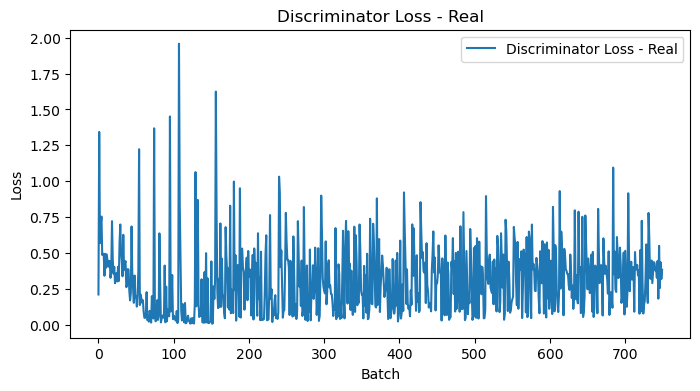

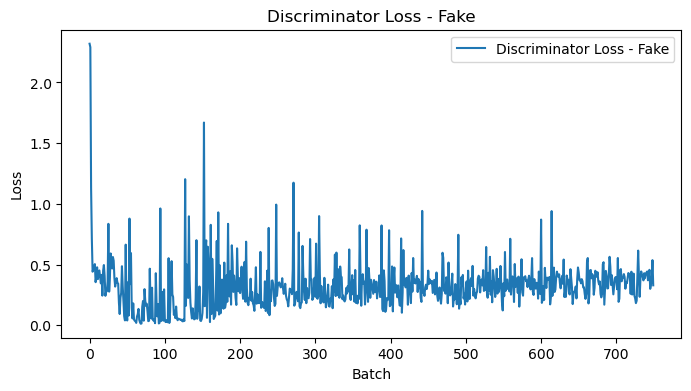

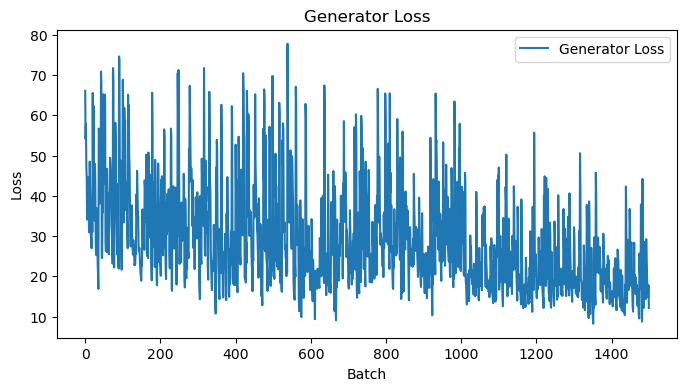

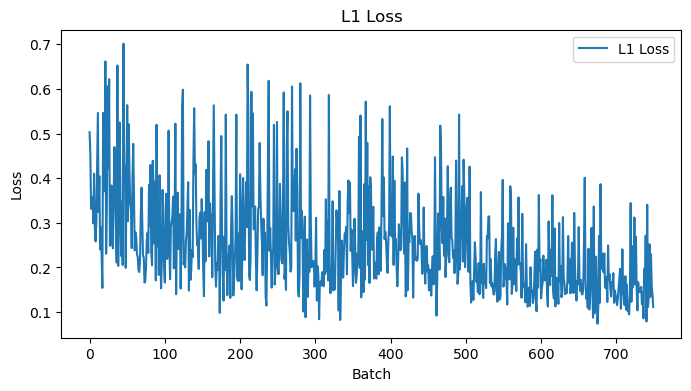

'l1_loss_values.csv'

In [12]:
# load image data
dataset = load_real_samples('maps_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Loaded (50, 256, 256, 3) (50, 256, 256, 3)
1/1 [==============================] - 2s 2s/step


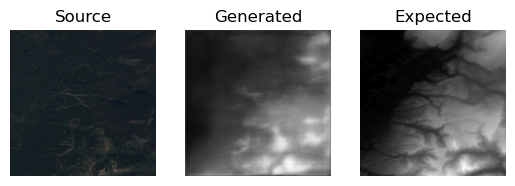

In [9]:
# example of loading a pix2pix model and using it for image to image translation
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint

# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()

# load dataset
[X1, X2] = load_real_samples('maps_256.npz')
print('Loaded', X1.shape, X2.shape)
# load model
model = load_model('model_000750.h5')
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)

Loaded (1, 256, 256, 3)
1/1 [==============================] - 2s 2s/step


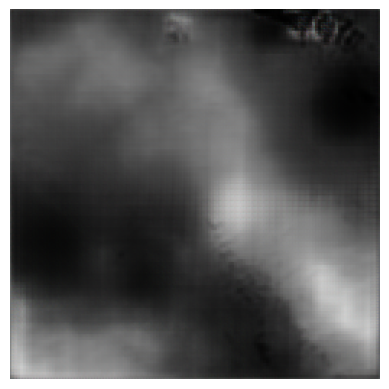

In [10]:
# example of loading a pix2pix model and using it for one-off image translation
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import load
from numpy import expand_dims
from matplotlib import pyplot

# load an image
def load_image(filename, size=(256,256)):
	# load image with the preferred size
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	# reshape to 1 sample
	pixels = expand_dims(pixels, 0)
	return pixels

# load source image
src_image = load_image('RGB_0.jpg')
print('Loaded', src_image.shape)
# load model
model = load_model('model_000750.h5')
# generate image from source
gen_image = model.predict(src_image)
# scale from [-1,1] to [0,1]
gen_image = (gen_image + 1) / 2.0
# plot the image
pyplot.imshow(gen_image[0])
pyplot.axis('off')
pyplot.show()